In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [44]:
# Read the files
data_fpt = pd.read_csv('FPT.csv')
data_msn = pd.read_csv('MSN.csv')
data_pnj = pd.read_csv('PNJ.csv')
data_vic = pd.read_csv('VIC.csv')

In [45]:
# Chuyển đổi cột Date/Time sang kiểu datetime
data_fpt['Date/Time'] = pd.to_datetime(data_fpt['Date/Time'])
data_msn['Date/Time'] = pd.to_datetime(data_msn['Date/Time'])
data_pnj['Date/Time'] = pd.to_datetime(data_pnj['Date/Time'])
data_vic['Date/Time'] = pd.to_datetime(data_vic['Date/Time'])

# Sắp xếp dữ liệu theo Date/Time
data_fpt.sort_values('Date/Time', inplace=True)
data_msn.sort_values('Date/Time', inplace=True)
data_pnj.sort_values('Date/Time', inplace=True)
data_vic.sort_values('Date/Time', inplace=True)


In [46]:
# Tạo các đặc trưng kỹ thuật
def calculate_indicators(data):
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    exp12 = data['Close'].ewm(span=12, adjust=False).mean()
    exp26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp12 - exp26
    
    data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2 * data['Close'].rolling(window=20).std()
    data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2 * data['Close'].rolling(window=20).std()
    
    data.dropna(inplace=True)
    return data

data_fpt = calculate_indicators(data_fpt)
data_msn = calculate_indicators(data_msn)
data_pnj = calculate_indicators(data_pnj)
data_vic = calculate_indicators(data_vic)



In [47]:

# Tính toán biến động giá cổ phiếu sau N ngày (N=1 trong trường hợp này)
N = 1
data_fpt['Price Change'] = data_fpt['Close'].shift(-N) - data_fpt['Close']
data_msn['Price Change'] = data_msn['Close'].shift(-N) - data_msn['Close']
data_pnj['Price Change'] = data_pnj['Close'].shift(-N) - data_pnj['Close']
data_vic['Price Change'] = data_vic['Close'].shift(-N) - data_vic['Close']

# Loại bỏ các giá trị NaN
data_fpt.dropna(inplace=True)
data_msn.dropna(inplace=True)
data_pnj.dropna(inplace=True)
data_vic.dropna(inplace=True)

In [52]:
# Hàm chuẩn bị dữ liệu cho LSTM với các đặc trưng kỹ thuật
def prepare_data_lstm(data, feature_cols, target_col='Price Change', time_steps=1):
    # Chuẩn hóa dữ liệu
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))

    features_scaled = scaler_features.fit_transform(data[feature_cols])
    target_scaled = scaler_target.fit_transform(data[[target_col]])

    X, y = [], []
    for i in range(len(features_scaled) - time_steps - 1):
        X.append(features_scaled[i:(i + time_steps)])
        y.append(target_scaled[i + time_steps])
    X = np.array(X)
    y = np.array(y)

    return train_test_split(X, y, test_size=0.2, random_state=42), scaler_features, scaler_target

# Các đặc trưng kỹ thuật được chọn
feature_cols = ['Open', 'High', 'Low','Close','Volume', 'MA_10', 'MA_50', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low']

# Chuẩn bị dữ liệu cho LSTM với các đặc trưng kỹ thuật
time_steps = 10
(X_train_fpt, X_test_fpt, y_train_fpt, y_test_fpt), scaler_features_fpt, scaler_target_fpt = prepare_data_lstm(data_fpt, feature_cols, time_steps=time_steps)
(X_train_msn, X_test_msn, y_train_msn, y_test_msn), scaler_features_msn, scaler_target_msn = prepare_data_lstm(data_msn, feature_cols, time_steps=time_steps)
(X_train_pnj, X_test_pnj, y_train_pnj, y_test_pnj), scaler_features_pnj, scaler_target_pnj = prepare_data_lstm(data_pnj, feature_cols, time_steps=time_steps)
(X_train_vic, X_test_vic, y_train_vic, y_test_vic), scaler_features_vic, scaler_target_vic = prepare_data_lstm(data_vic, feature_cols, time_steps=time_steps)

In [53]:
# Định hình lại dữ liệu để phù hợp với đầu vào của LSTM
X_train_fpt = np.reshape(X_train_fpt, (X_train_fpt.shape[0], X_train_fpt.shape[1], len(feature_cols)))
X_test_fpt = np.reshape(X_test_fpt, (X_test_fpt.shape[0], X_test_fpt.shape[1], len(feature_cols)))
X_train_msn = np.reshape(X_train_msn, (X_train_msn.shape[0], X_train_msn.shape[1], len(feature_cols)))
X_test_msn = np.reshape(X_test_msn, (X_test_msn.shape[0], X_test_msn.shape[1], len(feature_cols)))
X_train_pnj = np.reshape(X_train_pnj, (X_train_pnj.shape[0], X_train_pnj.shape[1], len(feature_cols)))
X_test_pnj = np.reshape(X_test_pnj, (X_test_pnj.shape[0], X_test_pnj.shape[1], len(feature_cols)))
X_train_vic = np.reshape(X_train_vic, (X_train_vic.shape[0], X_train_vic.shape[1], len(feature_cols)))
X_test_vic = np.reshape(X_test_vic, (X_test_vic.shape[0], X_test_vic.shape[1], len(feature_cols)))

In [54]:
def build_bidirectional_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=50, kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_regularizer=l2(0.001)))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Xây dựng mô hình LSTM hai chiều cho từng cổ phiếu
lstm_model_fpt = build_bidirectional_lstm_model((X_train_fpt.shape[1], X_train_fpt.shape[2]))
lstm_model_msn = build_bidirectional_lstm_model((X_train_msn.shape[1], X_train_msn.shape[2]))
lstm_model_pnj = build_bidirectional_lstm_model((X_train_pnj.shape[1], X_train_pnj.shape[2]))
lstm_model_vic = build_bidirectional_lstm_model((X_train_vic.shape[1], X_train_vic.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Huấn luyện mô hình
history_fpt = lstm_model_fpt.fit(X_train_fpt, y_train_fpt, epochs=50, batch_size=32, validation_data=(X_test_fpt, y_test_fpt), callbacks=[early_stopping], verbose=2)
history_msn = lstm_model_msn.fit(X_train_msn, y_train_msn, epochs=50, batch_size=32, validation_data=(X_test_msn, y_test_msn), callbacks=[early_stopping], verbose=2)
history_pnj = lstm_model_pnj.fit(X_train_pnj, y_train_pnj, epochs=50, batch_size=32, validation_data=(X_test_pnj, y_test_pnj), callbacks=[early_stopping], verbose=2)
history_vic = lstm_model_vic.fit(X_train_vic, y_train_vic, epochs=50, batch_size=32, validation_data=(X_test_vic, y_test_vic), callbacks=[early_stopping], verbose=2)

c:\Users\LEGION\OneDrive\Máy tính\finpros\venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2416/2416 - 35s - 14ms/step - loss: 0.0205 - val_loss: 6.9402e-04
Epoch 2/50
2416/2416 - 30s - 12ms/step - loss: 7.5947e-04 - val_loss: 3.2475e-04
Epoch 3/50
2416/2416 - 29s - 12ms/step - loss: 3.8717e-04 - val_loss: 2.9853e-04
Epoch 4/50
2416/2416 - 30s - 12ms/step - loss: 3.1205e-04 - val_loss: 2.9304e-04
Epoch 5/50
2416/2416 - 29s - 12ms/step - loss: 3.0227e-04 - val_loss: 2.9113e-04
Epoch 6/50
2416/2416 - 28s - 12ms/step - loss: 3.0125e-04 - val_loss: 2.9202e-04
Epoch 7/50
2416/2416 - 28s - 12ms/step - loss: 3.0154e-04 - val_loss: 2.9192e-04
Epoch 8/50
2416/2416 - 26s - 11ms/step - loss: 3.0187e-04 - val_loss: 2.9513e-04
Epoch 9/50
2416/2416 - 26s - 11ms/step - loss: 3.0209e-04 - val_loss: 2.9165e-04
Epoch 10/50
2416/2416 - 25s - 10ms/step - loss: 3.0253e-04 - val_loss: 2.9524e-04
Epoch 11/50
2416/2416 - 25s - 10ms/step - loss: 3.0197e-04 - val_loss: 2.9115e-04
Epoch 12/50
2416/2416 - 27s - 11ms/step - loss: 3.0178e-04 - val_loss: 2.9202e-04
Epoch 13/50
2416/2416 - 30s -

604/604 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
842/842 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
779/779 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Bidirectional LSTM - FPT: MAE=0.0337374325470466, RMSE=0.0629578936163522
Bidirectional LSTM - MSN: MAE=0.10252676277157483, RMSE=0.21777235054498476
Bidirectional LSTM - PNJ: MAE=0.3487724928503428, RMSE=0.691614571705096
Bidirectional LSTM - VIC: MAE=0.09265698177193217, RMSE=0.19185386432161275


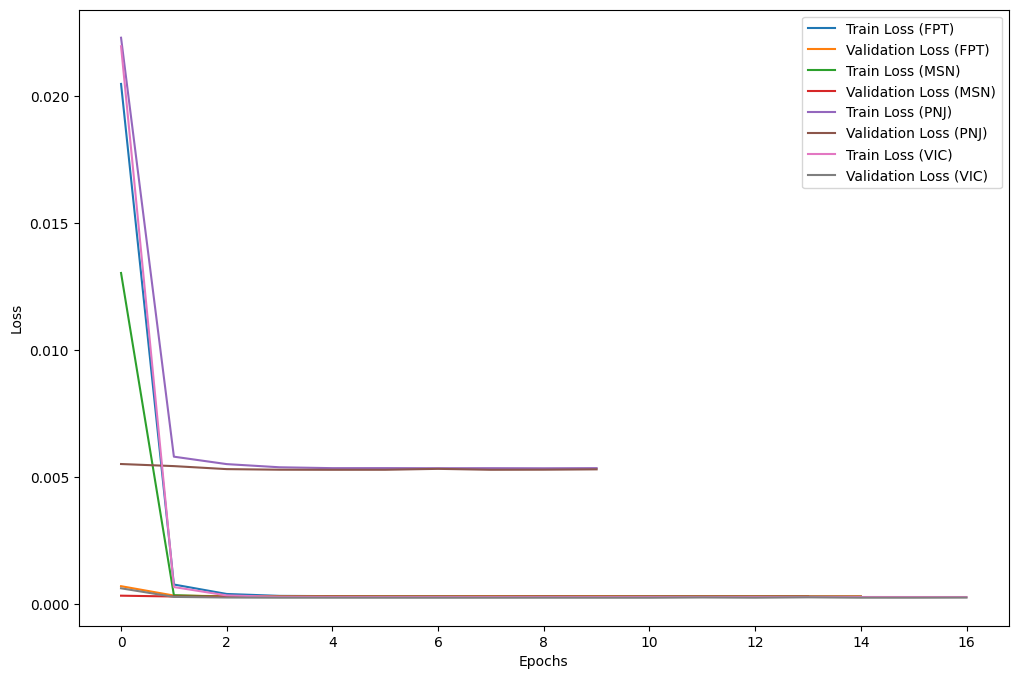

In [55]:

# Đánh giá mô hình LSTM hai chiều
def evaluate_lstm_model(model, X_test, y_test, scaler_target):
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return mae, rmse

mae_fpt, rmse_fpt = evaluate_lstm_model(lstm_model_fpt, X_test_fpt, y_test_fpt, scaler_target_fpt)
mae_msn, rmse_msn = evaluate_lstm_model(lstm_model_msn, X_test_msn, y_test_msn, scaler_target_msn)
mae_pnj, rmse_pnj = evaluate_lstm_model(lstm_model_pnj, X_test_pnj, y_test_pnj, scaler_target_pnj)
mae_vic, rmse_vic = evaluate_lstm_model(lstm_model_vic, X_test_vic, y_test_vic, scaler_target_vic)
# Hiển thị kết quả
print(f"Bidirectional LSTM - FPT: MAE={mae_fpt}, RMSE={rmse_fpt}")
print(f"Bidirectional LSTM - MSN: MAE={mae_msn}, RMSE={rmse_msn}")
print(f"Bidirectional LSTM - PNJ: MAE={mae_pnj}, RMSE={rmse_pnj}")
print(f"Bidirectional LSTM - VIC: MAE={mae_vic}, RMSE={rmse_vic}")
plt.figure(figsize=(12, 8))
plt.plot(history_fpt.history['loss'], label='Train Loss (FPT)')
plt.plot(history_fpt.history['val_loss'], label='Validation Loss (FPT)')
plt.plot(history_msn.history['loss'], label='Train Loss (MSN)')
plt.plot(history_msn.history['val_loss'], label='Validation Loss (MSN)')
plt.plot(history_pnj.history['loss'], label='Train Loss (PNJ)')
plt.plot(history_pnj.history['val_loss'], label='Validation Loss (PNJ)')
plt.plot(history_vic.history['loss'], label='Train Loss (VIC)')
plt.plot(history_vic.history['val_loss'], label='Validation Loss (VIC)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()